# Notebook utilizado para validar os modelos de Machine Learning.

In [1]:
# Ler dataset de validação.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk

csv = 'Data/Dados.csv'

dados = pd.read_csv(csv, sep=';')

# Separação da variável alvo.
x = dados.drop(columns=['inadimplencia'])
y = dados['inadimplencia']


# Tratamento das variáveis categóricas.
with open('MODELO/one_hot_enc.pkl', 'rb') as f:
    one_hot_enc = pk.load(f)

x = one_hot_enc.transform(x)
x = pd.DataFrame(x, columns=one_hot_enc.get_feature_names_out())

# Normalizando os Dados.
with open('MODELO/scaler.pkl', 'rb') as f:
    scaler = pk.load(f)

scaler.fit(x)
x = scaler.transform(x)


Separada com: 20,191 elementos de treino e 8,654 elementos para teste.
----------------------------------------------------------------------------------------------------
Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
GradientBoostingClassifier(learning_rate=1.0, max_depth=5, n_estimators=50,
                           random_state=80)
----------------------------------------------------------------------------------------------------
Validação Cruzada: Acuracia média : 88.13
.......................
Validação Cruzada: Margem : [86.32, 89.93]
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      6691
         1.0       0.85      0.74      0.79      1963



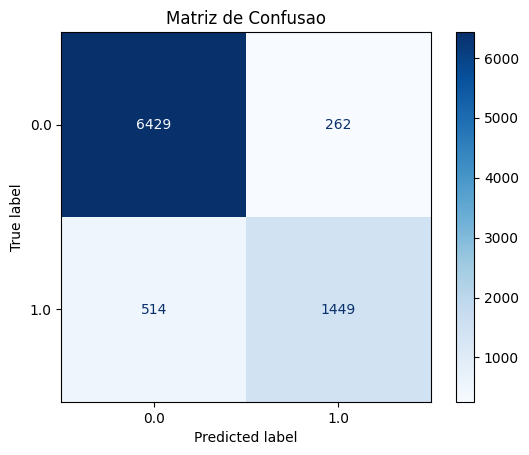

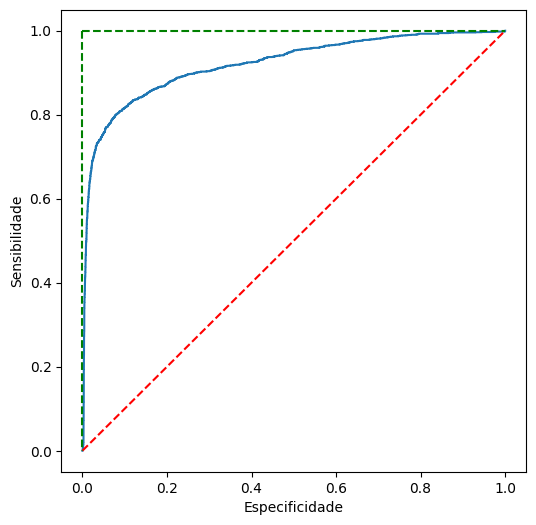

roc_auc: 0.9208958620444446


In [2]:

# Escolhi estes 3 modelos para comparar.
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Vamos rodar os modelos com pipeline.
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

SEED = 80
np.random.seed(SEED)

# Separação Treino e Teste.
treino_x, teste_x, treino_y, teste_y = train_test_split(
    x, y, test_size=0.30, random_state=0)
base_treino = treino_x.shape[0]
base_teste = teste_x.shape[0]

print('Separada com: %s elementos de treino e %s elementos para teste.' % (
    base_treino.__format__(',d'), base_teste.__format__(',d')))
print('-'*100)

scaler = StandardScaler()
modelo = GradientBoostingClassifier(
    n_estimators=50, learning_rate=1.0, max_depth=5, random_state=SEED)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

cv = GroupKFold(n_splits=2)
validacao = cross_validate(modelo, x, y,
                           cv=cv,
                           return_train_score=False,
                           groups=dados.faixa_idade)

media = validacao['test_score'].mean()
desvio_padrao = validacao['test_score'].std()
print('Validação Cruzada: Acuracia média : %.2f' % (media * 100))
print('.'*23)
print('Validação Cruzada: Margem : [%.2f, %.2f]' % ((media - 2 * desvio_padrao)
      * 100, (media + 2 * desvio_padrao)*100))
print('-'*100)

predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)

matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))


# Testando com OverSampling

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score

SEED = 80
np.random.seed(SEED)


# Balanceamento da Base de Dados.
resampler = SMOTE(random_state=SEED)
resampler_name = resampler.__getattribute__('__class__').__name__
x_resampled, y_resampled = resampler.fit_resample(x, y)

print('A Basse foi balanceada com: %s' % (resampler_name))
print('*'*36)

# Separação Treino e Teste.
treino_x, teste_x, treino_y, teste_y = train_test_split(
    x_resampled, y_resampled, test_size=0.30, random_state=0)
base_treino = treino_x.shape[0]
base_teste = teste_x.shape[0]

print('Separada com: %s elementos de treino e %s elementos para teste.' % (
    base_treino.__format__(',d'), base_teste.__format__(',d')))
print('-'*100)




A Basse foi balanceada com: SMOTE
************************************
Separada com: 31,637 elementos de treino e 13,559 elementos para teste.
----------------------------------------------------------------------------------------------------


Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
GradientBoostingClassifier(learning_rate=1.0, max_depth=5, n_estimators=50,
                           random_state=80)
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      6731
         1.0       0.96      0.92      0.94      6828

    accuracy                           0.94     13559
   macro avg       0.94      0.94      0.94     13559
weighted avg       0.94      0.94      0.94     13559

.....................................................


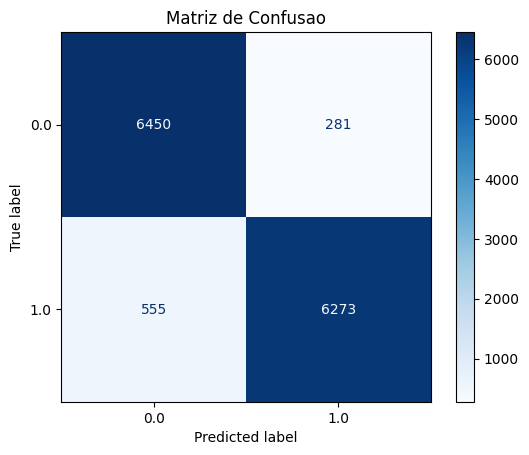

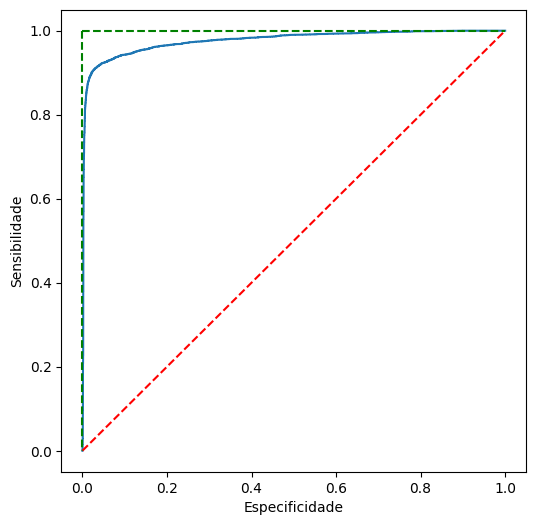

roc_auc: 0.9768624687407989


C:\Users\PauloVinicius\AppData\Local\Temp\ipykernel_4796\3747236645.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_over = metricas_over.append({'Modelo': 'Gradient Boosting',


,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.968265,0.938344,0.918717,0.976862


In [4]:
#Gradient Boosting

scaler = StandardScaler()
modelo = GradientBoostingClassifier(
    n_estimators=50, learning_rate=1.0, max_depth=5, random_state=SEED)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)


matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))

#Gravar Métricas Para Comparação.
metricas_over = pd.DataFrame(columns=[
                             'Modelo', 
                             'Acurácia Treino', 
                             'Acurácia Teste', 
                             'Recall', 
                             'AUC'])



metricas_over = metricas_over.append({'Modelo': 'Gradient Boosting',
                                      'Acurácia Treino': pipeline.score(treino_x, treino_y),
                                      'Acurácia Teste': pipeline.score(teste_x, teste_y),
                                      'Recall': recall_score(teste_y, predicao),
                                      'AUC': roc_auc_score(teste_y, prob_previsao)}, ignore_index=True)

metricas_over.head()

Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
DecisionTreeClassifier(random_state=80)
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88      6731
         1.0       0.88      0.89      0.88      6828

    accuracy                           0.88     13559
   macro avg       0.88      0.88      0.88     13559
weighted avg       0.88      0.88      0.88     13559

.....................................................


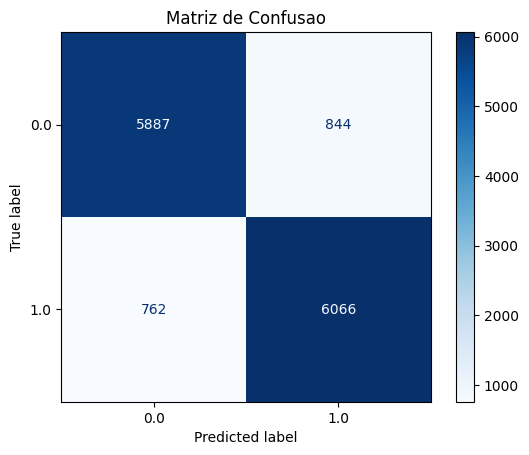

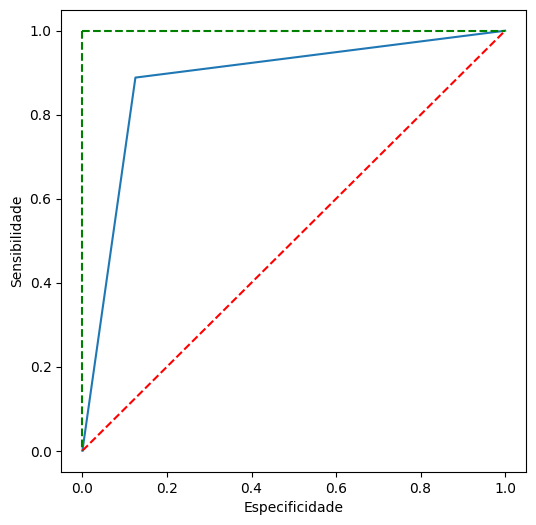

roc_auc: 0.881505358179334


C:\Users\PauloVinicius\AppData\Local\Temp\ipykernel_4796\4167815217.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_over = metricas_over.append({'Modelo': 'Decision Tree',


,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.968265,0.938344,0.918717,0.976862
1,Decision Tree,1.000000,0.881555,0.888401,0.881505


In [5]:
#Decision Tree

scaler = StandardScaler()
modelo = decision_tree = DecisionTreeClassifier(random_state=SEED)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)


matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))

metricas_over = metricas_over.append({'Modelo': 'Decision Tree',
                                      'Acurácia Treino': pipeline.score(treino_x, treino_y),
                                      'Acurácia Teste': pipeline.score(teste_x, teste_y),
                                      'Recall': recall_score(teste_y, predicao),
                                      'AUC': roc_auc_score(teste_y, prob_previsao)}, ignore_index=True)

metricas_over.head()


Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
RandomForestClassifier(random_state=80)
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      6731
         1.0       0.96      0.91      0.93      6828

    accuracy                           0.93     13559
   macro avg       0.94      0.93      0.93     13559
weighted avg       0.94      0.93      0.93     13559

.....................................................


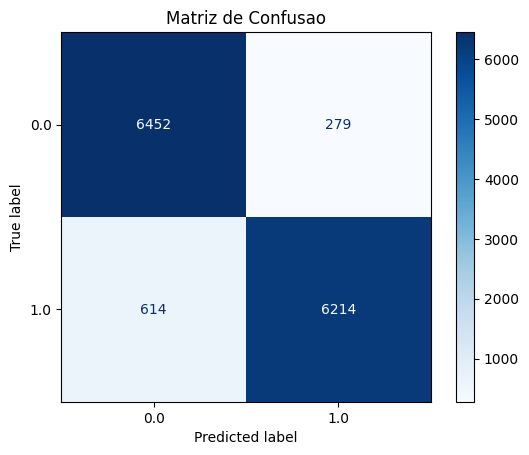

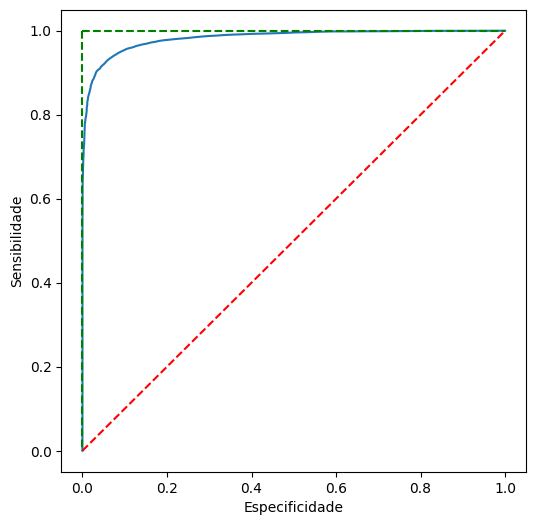

roc_auc: 0.9827355714194578


C:\Users\PauloVinicius\AppData\Local\Temp\ipykernel_4796\2134569865.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_over = metricas_over.append({'Modelo': 'RandomForestClassifier',


In [6]:
#Random Forest

scaler = StandardScaler()
modelo = RandomForestClassifier(random_state=SEED)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)


matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))


metricas_over = metricas_over.append({'Modelo': 'RandomForestClassifier',
                                      'Acurácia Treino': pipeline.score(treino_x, treino_y),
                                      'Acurácia Teste': pipeline.score(teste_x, teste_y),
                                      'Recall': recall_score(teste_y, predicao),
                                      'AUC': roc_auc_score(teste_y, prob_previsao)}, ignore_index=True)


In [7]:
metricas_over.head()
                                

,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.968265,0.938344,0.918717,0.976862
1,Decision Tree,1.000000,0.881555,0.888401,0.881505
2,RandomForestClassifier,1.000000,0.934140,0.910076,0.982736


# Testando com Under Sampling

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

SEED = 80
np.random.seed(SEED)


# Balanceamento da Base de Dados.
resampler = NearMiss(version=1, n_neighbors_ver3=3)
# resampler = RandomUnderSampler(random_state=SEED)
resampler_name = resampler.__getattribute__('__class__').__name__
x_resampled, y_resampled = resampler.fit_resample(x, y)

print('A Basse foi balanceada com: %s' % (resampler_name))
print('*'*36)

# Separação Treino e Teste.
treino_x, teste_x, treino_y, teste_y = train_test_split(
    x_resampled, y_resampled, test_size=0.30, random_state=0)
base_treino = treino_x.shape[0]
base_teste = teste_x.shape[0]

print('Separada com: %s elementos de treino e %s elementos para teste.' % (
    base_treino.__format__(',d'), base_teste.__format__(',d')))
print('-'*100)



A Basse foi balanceada com: NearMiss
************************************
Separada com: 8,745 elementos de treino e 3,749 elementos para teste.
----------------------------------------------------------------------------------------------------


Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
GradientBoostingClassifier(learning_rate=1.0, max_depth=5, n_estimators=50,
                           random_state=80)
----------------------------------------------------------------------------------------------------
Validação Cruzada: Acuracia média : 88.13
.......................
Validação Cruzada: Margem : [86.32, 89.93]
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1839
         1.0       0.91      0.88      0.90      1910

    accuracy                           0.90      3749
   macro avg       0.90      0.90      0.90      3749
weighted avg       0.90      0.90      0.90      3749

.........

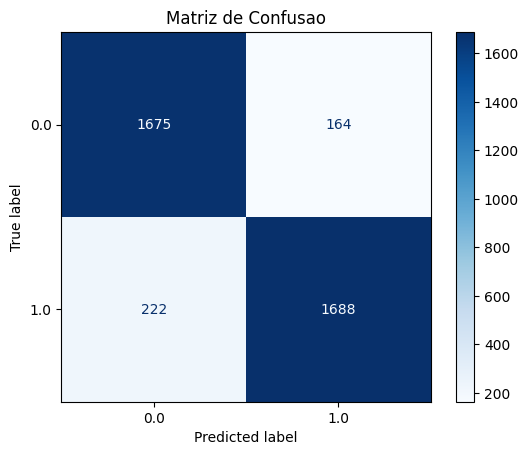

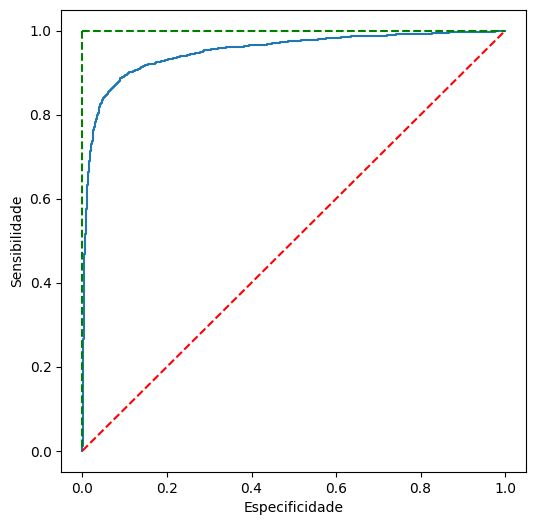

roc_auc: 0.9513447725118078


C:\Users\PauloVinicius\AppData\Local\Temp\ipykernel_4796\640423965.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_under = metricas_under.append({'Modelo': 'Gradient Boosting',


,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.985477,0.897039,0.88377,0.951345


In [11]:
#Gradient Boosting
scaler = StandardScaler()
modelo = GradientBoostingClassifier(
    n_estimators=50, learning_rate=1.0, max_depth=5, random_state=SEED)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

# Retirar balanceamento para veriricar impacto.
# cv = StratifiedKFold(n_splits=3, shuffle=True)
cv = GroupKFold(n_splits=2)

validacao = cross_validate(modelo, x, y, 
                           cv=cv,
                           return_train_score=False,
                           groups= dados.faixa_idade)

media = validacao['test_score'].mean()
desvio_padrao = validacao['test_score'].std()
print('Validação Cruzada: Acuracia média : %.2f' % (media * 100))
print('.'*23)
print('Validação Cruzada: Margem : [%.2f, %.2f]' % ((media - 2 * desvio_padrao)
      * 100, (media + 2 * desvio_padrao)*100))
print('-'*100)


predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)


matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))

#Gravar Métricas Para Comparação.
metricas_under = pd.DataFrame(columns=[
                             'Modelo',
                             'Acurácia Treino',
                             'Acurácia Teste',
                             'Recall',
                             'AUC'])

metricas_under = metricas_under.append({'Modelo': 'Gradient Boosting',
                                      'Acurácia Treino': pipeline.score(treino_x, treino_y),
                                      'Acurácia Teste': pipeline.score(teste_x, teste_y),
                                      'Recall': recall_score(teste_y, predicao),
                                      'AUC': roc_auc_score(teste_y, prob_previsao)}, ignore_index=True)

metricas_under.head()

Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
DecisionTreeClassifier(random_state=80)
----------------------------------------------------------------------------------------------------
Validação Cruzada: Acuracia média : 80.73
.......................
Validação Cruzada: Margem : [78.76, 82.70]
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      2211
         1.0       0.78      0.78      0.78      2219

    accuracy                           0.78      4430
   macro avg       0.78      0.78      0.78      4430
weighted avg       0.78      0.78      0.78      4430

.....................................................


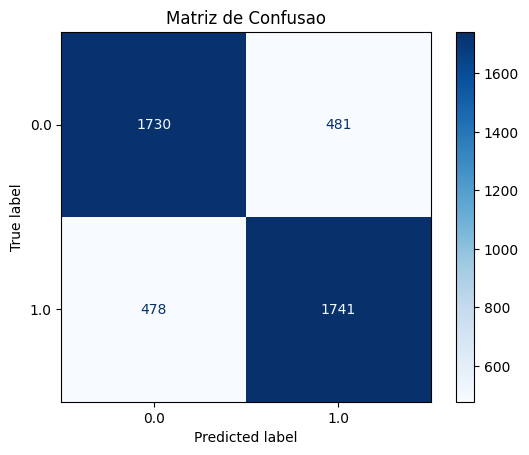

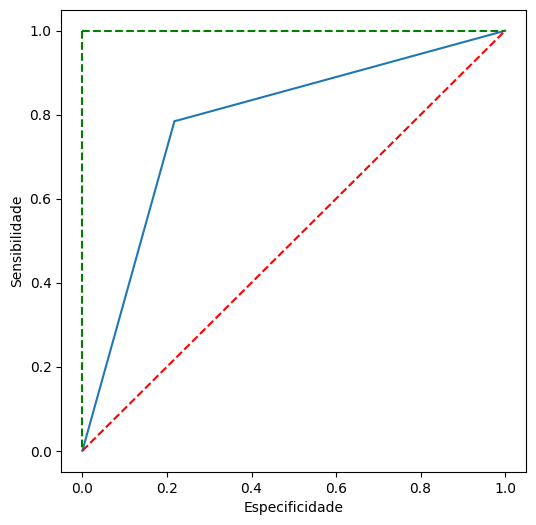

roc_auc: 0.7833667501730971


C:\Users\PauloVinicius\AppData\Local\Temp\ipykernel_17248\711422864.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_under = metricas_under.append({'Modelo': 'Decision Tree',


,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.923069,0.839729,0.811176,0.905868
1,Decision Tree,0.998065,0.783521,0.784588,0.783367


In [11]:
#Decision Tree
scaler = StandardScaler()
modelo = DecisionTreeClassifier(random_state=SEED)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

# Retirar balanceamento para veriricar impacto.
# cv = StratifiedKFold(n_splits=3, shuffle=True)
cv = GroupKFold(n_splits=2)

validacao = cross_validate(modelo, x, y, 
                           cv=cv,
                           return_train_score=False,
                           groups= dados.faixa_idade)

media = validacao['test_score'].mean()
desvio_padrao = validacao['test_score'].std()
print('Validação Cruzada: Acuracia média : %.2f' % (media * 100))
print('.'*23)
print('Validação Cruzada: Margem : [%.2f, %.2f]' % ((media - 2 * desvio_padrao)
      * 100, (media + 2 * desvio_padrao)*100))
print('-'*100)


predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)


matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))

#Gravar Métricas Para Comparação.

metricas_under = metricas_under.append({'Modelo': 'Decision Tree',
                                      'Acurácia Treino': pipeline.score(treino_x, treino_y),
                                      'Acurácia Teste': pipeline.score(teste_x, teste_y),
                                      'Recall': recall_score(teste_y, predicao),
                                      'AUC': roc_auc_score(teste_y, prob_previsao)}, ignore_index=True)

metricas_under.head()

Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
RandomForestClassifier(random_state=80)
----------------------------------------------------------------------------------------------------
Validação Cruzada: Acuracia média : 88.85
.......................
Validação Cruzada: Margem : [88.33, 89.36]
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      2211
         1.0       0.87      0.80      0.83      2219

    accuracy                           0.84      4430
   macro avg       0.84      0.84      0.84      4430
weighted avg       0.84      0.84      0.84      4430

.....................................................


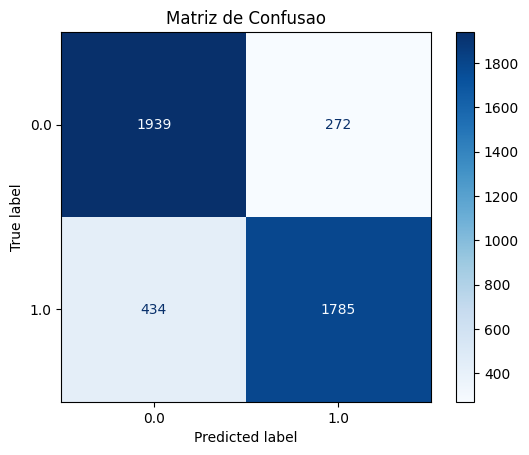

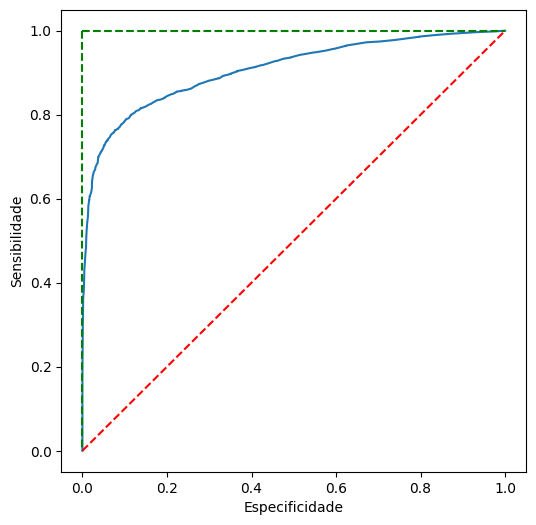

roc_auc: 0.9071300264623867


C:\Users\PauloVinicius\AppData\Local\Temp\ipykernel_17248\2893635001.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_under = metricas_under.append({'Modelo': 'Random Forest',


,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.923069,0.839729,0.811176,0.905868
1,Decision Tree,0.998065,0.783521,0.784588,0.783367
2,Random Forest,0.997968,0.840632,0.804416,0.907130


In [12]:
#Random Forest
scaler = StandardScaler()
modelo = RandomForestClassifier(random_state=SEED)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

# Retirar balanceamento para veriricar impacto.
# cv = StratifiedKFold(n_splits=3, shuffle=True)
cv = GroupKFold(n_splits=2)

validacao = cross_validate(modelo, x, y, 
                           cv=cv,
                           return_train_score=False,
                           groups= dados.faixa_idade)

media = validacao['test_score'].mean()
desvio_padrao = validacao['test_score'].std()
print('Validação Cruzada: Acuracia média : %.2f' % (media * 100))
print('.'*23)
print('Validação Cruzada: Margem : [%.2f, %.2f]' % ((media - 2 * desvio_padrao)
      * 100, (media + 2 * desvio_padrao)*100))
print('-'*100)


predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)


matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))


metricas_under = metricas_under.append({'Modelo': 'Random Forest',
                                      'Acurácia Treino': pipeline.score(treino_x, treino_y),
                                      'Acurácia Teste': pipeline.score(teste_x, teste_y),
                                      'Recall': recall_score(teste_y, predicao),
                                      'AUC': roc_auc_score(teste_y, prob_previsao)}, ignore_index=True)

metricas_under.head()

# Comparando

In [13]:
display(metricas_over, metricas_under)

,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.946503,0.925835,0.898505,0.966560
1,Decision Tree,0.999433,0.888028,0.894737,0.888176
2,RandomForestClassifier,0.999433,0.931191,0.905414,0.978310


,Modelo,Acurácia Treino,Acurácia Teste,Recall,AUC
0,Gradient Boosting,0.923069,0.839729,0.811176,0.905868
1,Decision Tree,0.998065,0.783521,0.784588,0.783367
2,Random Forest,0.997968,0.840632,0.804416,0.907130


# Otimizando Parametros do Modelo

A Basse possui: 33,832 elementos.
----------------------------------------------------------------------------------------------------
A Basse foi balanceada com: SMOTE
************************************
Separada com: 37,030 elementos de treino e 15,870 elementos para teste.
----------------------------------------------------------------------------------------------------
Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
GradientBoostingClassifier(max_depth=8, max_features='sqrt', random_state=80,
                           subsample=0.5)
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93      7909
         1.0       0.95      0.90      0.92      7961

   

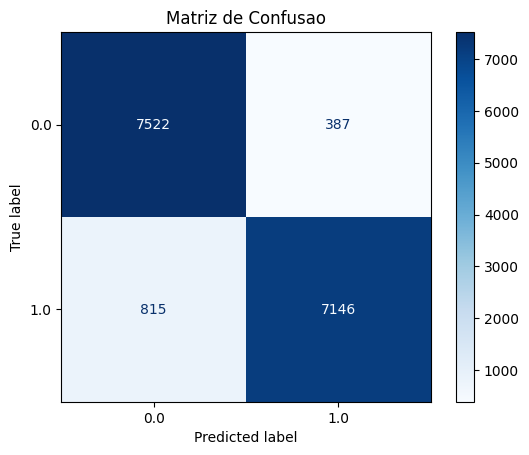

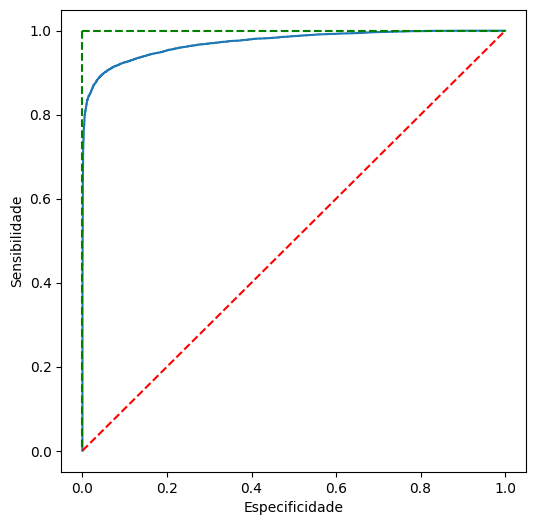

roc_auc: 0.9723432362429252


In [14]:
#Modelo Escolhido
# Gradient Boosting Over Sampling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score

SEED = 80
np.random.seed(SEED)

csv = 'Data/Dados.csv'

base_dados = pd.read_csv(csv).drop(
    columns=['pessoa_id', 'pessoa_idade', 'salario_ano', 'vl_total'])

y = base_dados['inadimplencia']
x = base_dados.drop(columns=['inadimplencia'])

print('A Basse possui: %s elementos.' % (x.shape[0].__format__(',d')))
print('-'*100)

#Normalizando os Dados.
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

# Balanceamento da Base de Dados.
resampler = SMOTE(random_state=SEED)
resampler_name = resampler.__getattribute__('__class__').__name__
x_resampled, y_resampled = resampler.fit_resample(x, y)

print('A Basse foi balanceada com: %s' % (resampler_name))
print('*'*36)

# Separação Treino e Teste.
treino_x, teste_x, treino_y, teste_y = train_test_split(
    x_resampled, y_resampled, test_size=0.30, random_state=0)
base_treino = treino_x.shape[0]
base_teste = teste_x.shape[0]

print('Separada com: %s elementos de treino e %s elementos para teste.' % (
    base_treino.__format__(',d'), base_teste.__format__(',d')))
print('-'*100)


scaler = StandardScaler()
modelo = GradientBoostingClassifier(loss='log_loss', max_depth=8, max_features='sqrt',
                                                                random_state=80, subsample=0.5)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

predicao = pipeline.predict(teste_x)

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)


matriz_confusao = ConfusionMatrixDisplay.from_estimator(
    pipeline, teste_x, teste_y, cmap='Blues')
plt.title('Matriz de Confusao')

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]


tfp, tvp, limite = roc_curve(teste_y, prob_previsao)

plt.figure(figsize=(6, 6))
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c='red')
plt.plot([0, 0], [1, 0], ls="--",
         c='green'), plt.plot([1, 1], ls="--", c='green')
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()
print('roc_auc:', roc_auc_score(teste_y, prob_previsao))




In [18]:
from sklearn.model_selection import GridSearchCV

parametros = {
    "loss": ["deviance"],
    "max_depth": [3, 5, 8],
    "max_features": ["sqrt", "log2"],
    "criterion": ["friedman_mse", "absolute_error"],
    "subsample": [0.5, 0.618, 0.8, 0.85, 0.9],
    "n_estimators": [10, 100]
}



In [20]:
grid = GridSearchCV(GradientBoostingClassifier(
    random_state=SEED), parametros, scoring='recall', cv=3, verbose=1)


grid.fit(treino_x, treino_y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


c:\Users\PauloVinicius\Documents\GitHub\AluraChallengeDataScience2\ambienteAluraChallengeDados\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\PauloVinicius\Documents\GitHub\AluraChallengeDataScience2\ambienteAluraChallengeDados\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\PauloVinicius\Documents\GitHub\AluraChallengeDataScience2\ambienteAluraChallengeDados\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\PauloVinic

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=80),
             param_grid={'criterion': ['friedman_mse', 'absolute_error'],
                         'loss': ['deviance'], 'max_depth': [3, 5, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100],
                         'subsample': [0.5, 0.618, 0.8, 0.85, 0.9]},
             scoring='recall', verbose=1)

In [21]:
previsao_grid_search = grid.best_estimator_
previsao_grid = previsao_grid_search.predict(teste_x)


In [22]:
grid.best_estimator_


GradientBoostingClassifier(loss='deviance', max_depth=8, max_features='sqrt',
                           random_state=80, subsample=0.85)

In [23]:
print(classification_report(teste_y, previsao_grid))


              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93      7909
         1.0       0.95      0.90      0.92      7961

    accuracy                           0.92     15870
   macro avg       0.93      0.92      0.92     15870
weighted avg       0.93      0.92      0.92     15870



A Basse possui: 33,832 elementos.
----------------------------------------------------------------------------------------------------
A Basse foi balanceada com: SMOTE
************************************
Separada com: 37,030 elementos de treino e 15,870 elementos para teste.
----------------------------------------------------------------------------------------------------
Definição do Pipeline
----------------------------------------------------------------------------------------------------
StandardScaler()
****************
GradientBoostingClassifier(max_depth=8, max_features='sqrt', random_state=80,
                           subsample=0.85)
----------------------------------------------------------------------------------------------------
Classification Report
.....................................................
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      7909
         1.0       0.95      0.89      0.92      7961

  

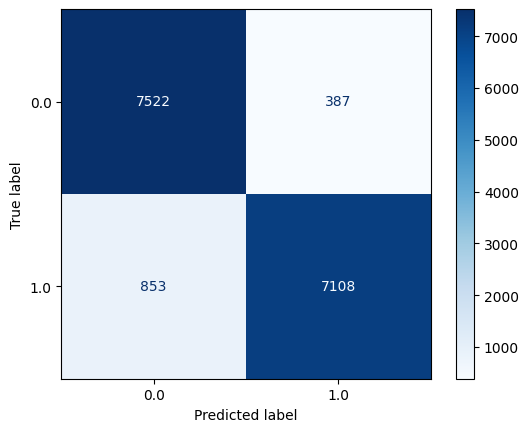

In [3]:
#Modelo Escolhido
# Gradient Boosting Over Sampling com metodo SMOTE.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score

SEED = 80
np.random.seed(SEED)

csv = 'Data/Dados.csv'

base_dados = pd.read_csv(csv).drop(
    columns=['pessoa_id', 'pessoa_idade', 'salario_ano', 'vl_total'])

y = base_dados['inadimplencia']
x = base_dados.drop(columns=['inadimplencia'])

print('A Basse possui: %s elementos.' % (x.shape[0].__format__(',d')))
print('-'*100)

#Normalizando os Dados.
# scaler = StandardScaler()
# scaler.fit(x)
# x = scaler.transform(x)

# Balanceamento da Base de Dados.
resampler = SMOTE(random_state=SEED)
resampler_name = resampler.__getattribute__('__class__').__name__
x_resampled, y_resampled = resampler.fit_resample(x, y)

print('A Basse foi balanceada com: %s' % (resampler_name))
print('*'*36)

# Separação Treino e Teste.
treino_x, teste_x, treino_y, teste_y = train_test_split(
    x_resampled, y_resampled, test_size=0.30, random_state=0)
base_treino = treino_x.shape[0]
base_teste = teste_x.shape[0]

print('Separada com: %s elementos de treino e %s elementos para teste.' % (
    base_treino.__format__(',d'), base_teste.__format__(',d')))
print('-'*100)


scaler = StandardScaler()
modelo = GradientBoostingClassifier(loss='log_loss', max_depth=8, max_features='sqrt',
                                    random_state=80, subsample=0.85)

pipeline = Pipeline([('scaler', scaler), ('estimador', modelo)])

print('Definição do Pipeline')
print('-'*100)
print(pipeline.named_steps['scaler'])
print('*'*16)
print(pipeline.named_steps['estimador'])
print('-'*100)

pipeline.fit(treino_x, treino_y)

predicao = pipeline.predict(teste_x)

dfpredicao = pd.DataFrame(predicao, columns=['predicao'])
dfpredicao.to_excel('Data/Previsao_TesteModelo.xlsx')

dfteste_x = pd.DataFrame(teste_x)
dfteste_x.to_excel('data/Teste_x.xlsx')

print('Classification Report')
print('.'*53)
print(classification_report(teste_y, predicao))
print('.'*53)

prob_previsao = pipeline.predict_proba(teste_x)[:, 1]

print('roc_auc:', roc_auc_score(teste_y, prob_previsao))

matriz_confusao = ConfusionMatrixDisplay.from_estimator(pipeline, teste_x, teste_y, cmap='Blues')